<a href="https://colab.research.google.com/github/hooymana/ASNR_2025_DataScience/blob/main/PYTHON_COMPLETED_randomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Example in Python

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from yellowbrick.classifier import ROCAUC


Importing and cleaning data

In [2]:
# data import and cleaning
url = "https://raw.githubusercontent.com/hooymana/CSM_Data-Visualization_2025/main/healthcare-dataset-stroke-data.csv"
stroke_data = pd.read_csv(url, na_values=["", "N/A", "NaN", "NA"])
stroke_data['stroke'] = stroke_data['stroke'].astype('category')
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Raincloud like plot

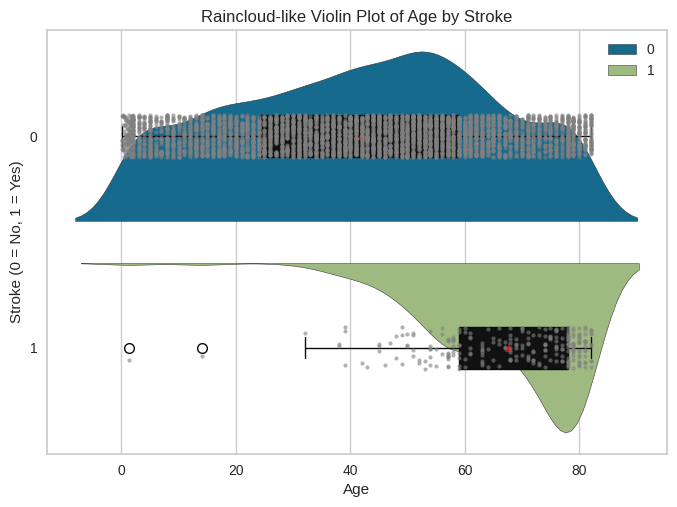

In [3]:

# Raincloud like plot
sns.violinplot(data=stroke_data, y='stroke', x='age', hue='stroke', split=True, orient='h', inner=None)  # Remove inner boxplot
sns.boxplot(data=stroke_data, y='stroke', x='age', orient='h', width=0.2, color='k', showmeans=True) # Add boxplot separately
sns.stripplot(data=stroke_data, y='stroke', x='age', orient='h', color='grey', size=3, jitter=0.1, alpha=0.6) # Add jittered points

plt.title("Raincloud-like Violin Plot of Age by Stroke")
plt.ylabel("Stroke (0 = No, 1 = Yes)")
plt.xlabel("Age")
plt.show()

Fitting and plotting a linear model

                            OLS Regression Results                            
Dep. Variable:      avg_glucose_level   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     113.6
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           3.25e-71
Time:                        15:54:51   Log-Likelihood:                -26564.
No. Observations:                5109   AIC:                         5.314e+04
Df Residuals:                    5105   BIC:                         5.316e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          86.4317      1.341     

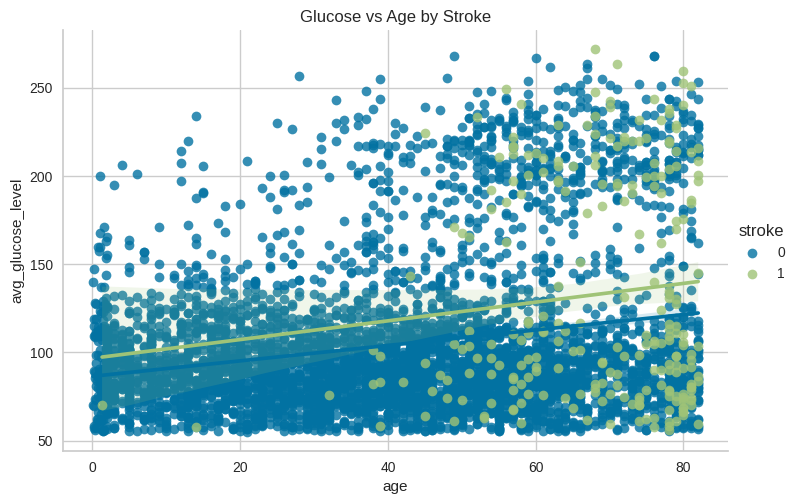

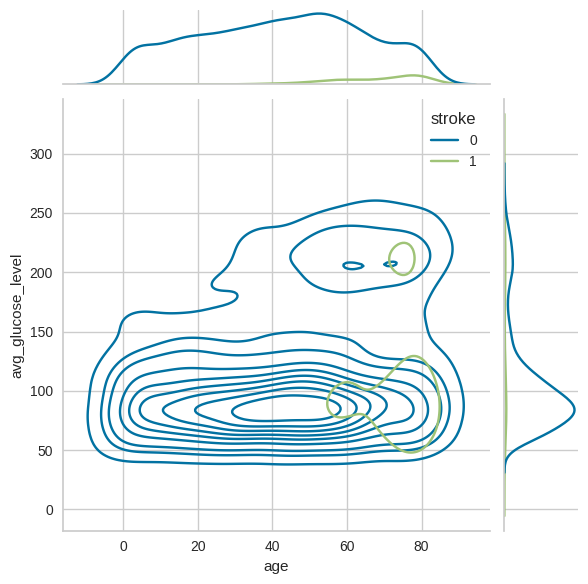

In [ ]:
# linear trend with  scatter
from scipy.stats import linregress

# Linear model stats
model = smf.ols('avg_glucose_level ~ age * stroke', data=stroke_data).fit()
print(model.summary())

# Trendlines
sns.lmplot(data=stroke_data, x='age', y='avg_glucose_level', hue='stroke', aspect=1.5)
plt.title("Glucose vs Age by Stroke")
plt.show()

# I cannot get this to work correctly : P
# Marginal plots
import seaborn as sns
sns.jointplot(data=stroke_data, x='age', y='avg_glucose_level', hue='stroke', kind='kde')


Logistic Regression

In [ ]:
# prompt: show me the data type, levels of the residence type variable, and how the residency type is coded, include cross tabs with work_type
# Check data type of 'Residence_type'
print(stroke_data['Residence_type'].dtype)

# Get levels of 'Residence_type'
print(stroke_data['Residence_type'].unique())

# Cross-tabulation of 'Residence_type' and 'work_type'
print(pd.crosstab(stroke_data['Residence_type'], stroke_data['work_type']))


object
['Urban' 'Rural']
work_type       Govt_job  Never_worked  Private  Self-employed  children
Residence_type                                                          
Rural                312             7     1461            393       340
Urban                345            15     1463            426       347


In [ ]:
# Define the formula for the logistic regression
formula = 'stroke ~ age + hypertension + heart_disease + avg_glucose_level + bmi + gender + ever_married + Residence_type + work_type + smoking_status'
# smf.logit does not work (singularity warning)
# smf.glm with family=binomial() does

# Convert 'stroke' column to numeric (0 and 1)
stroke_data['stroke'] = pd.to_numeric(stroke_data['stroke'])

# Fit the logistic regression model
model = smf.glm(formula=formula, data=stroke_data, family=sm.families.Binomial()).fit()

# Print the model summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                 4908
Model:                            GLM   Df Residuals:                     4892
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -681.61
Date:                Wed, 23 Apr 2025   Deviance:                       1363.2
Time:                        15:55:04   Pearson chi2:                 3.99e+03
No. Iterations:                    22   Pseudo R-squ. (CS):            0.07168
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

Changing the reference level to match R output

In [ ]:
# prompt: How can the levels of all the categorical factors in the stroke_data dataset

# Iterate through all columns in the DataFrame
for col in stroke_data.columns:
    # Check if the data type is 'category' or 'object' (string)
    if stroke_data[col].dtype == 'category' or stroke_data[col].dtype == 'object':
        # Print the column name and its unique values (levels)
        print(f"Levels of categorical factor '{col}':")
        print(stroke_data[col].unique())
        print("-" * 20)


Levels of categorical factor 'gender':
['Male' 'Female']
--------------------
Levels of categorical factor 'ever_married':
['Yes' 'No']
--------------------
Levels of categorical factor 'work_type':
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
--------------------
Levels of categorical factor 'Residence_type':
['Urban' 'Rural']
--------------------
Levels of categorical factor 'smoking_status':
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
--------------------


In [ ]:
# Gender
stroke_data['gender'] = pd.Categorical(stroke_data['gender'], categories=['Female', 'Male'], ordered=True)
# Ever Married
stroke_data['ever_married'] = pd.Categorical(stroke_data['ever_married'], categories=['No', 'Yes'], ordered=True)
# Work Type
stroke_data['work_type'] = pd.Categorical(stroke_data['work_type'], categories=['children', 'Govt_job', 'Never_worked', 'Private', 'Self-employed'], ordered=True)
# Residence Type
stroke_data['Residence_type'] = pd.Categorical(stroke_data['Residence_type'], categories=['Rural', 'Urban'], ordered=True)
# Smoking Status
stroke_data['smoking_status'] = pd.Categorical(stroke_data['smoking_status'], categories=['formerly smoked', 'never smoked', 'smokes', 'Unknown'], ordered=True)


Refit the Model

In [ ]:
# Define the formula for the logistic regression
formula = 'stroke ~ gender + age + hypertension + heart_disease + ever_married + work_type + Residence_type + avg_glucose_level + bmi +  smoking_status'
# Note that the coefficients from R and Python still do not match perfectly!
# For one, they are not in the same order so check your row numbers
# for two, the work_type[never_worked] coefficients are way off!
# To my knowledge, both of these function use IRLS and the logit link function by default
# notably, the R model converges sooner (after 14 Fisher interations rather than 22 for Python)

# Convert 'stroke' column to numeric (0 and 1)
stroke_data['stroke'] = pd.to_numeric(stroke_data['stroke'])

# Fit the logistic regression model
model = smf.glm(formula=formula, data=stroke_data, family=sm.families.Binomial()).fit()

# Print the model summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                 4908
Model:                            GLM   Df Residuals:                     4892
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -681.61
Date:                Wed, 23 Apr 2025   Deviance:                       1363.2
Time:                        15:55:05   Pearson chi2:                 3.99e+03
No. Iterations:                    22   Pseudo R-squ. (CS):            0.07168
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [ ]:
# Extract Odds Ratios (OR), Confidence Intervals (CI), and p-values
odds_ratios = np.exp(model.params).round(3)
conf = np.exp(model.conf_int()).round(3)
pvals = model.pvalues.round(3)

# Create a DataFrame to display results
results_df = pd.DataFrame({
    'OR': odds_ratios,
    'lower.CI': conf[0],
    'upper.CI': conf[1],
    'p.value': pvals
})

# Print the results
print(results_df)

                                   OR  lower.CI  upper.CI  p.value
Intercept                       0.001     0.000     0.005    0.000
gender[T.Male]                  0.985     0.728     1.334    0.925
ever_married[T.Yes]             0.891     0.549     1.447    0.641
work_type[T.Govt_job]           0.506     0.057     4.491    0.541
work_type[T.Never_worked]       0.000     0.000       inf    0.999
work_type[T.Private]            0.594     0.069     5.133    0.636
work_type[T.Self-employed]      0.388     0.043     3.480    0.398
Residence_type[T.Urban]         1.005     0.749     1.348    0.976
smoking_status[T.never smoked]  0.935     0.646     1.353    0.722
smoking_status[T.smokes]        1.369     0.873     2.146    0.171
smoking_status[T.Unknown]       0.759     0.468     1.232    0.265
age                             1.076     1.063     1.090    0.000
hypertension                    1.690     1.199     2.382    0.003
heart_disease                   1.417     0.944     2.127    0

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


# Setting up the ML Pipeline

In [ ]:
# set up ML pipeline
X = stroke_data.drop(columns=['id', 'stroke'])
y = stroke_data['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify=y)


# Split by dtype
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Cross Validation to Tune the Random Forest Model

In [ ]:
# Cross validation and tuning random forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=1000, random_state=234))
])

param_grid = {
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__min_samples_split': [2, 5, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=234)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)


{'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 10}


Variable Importantance Plot

<ipython-input-13-17ddde73116e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature', palette='Blues_d')


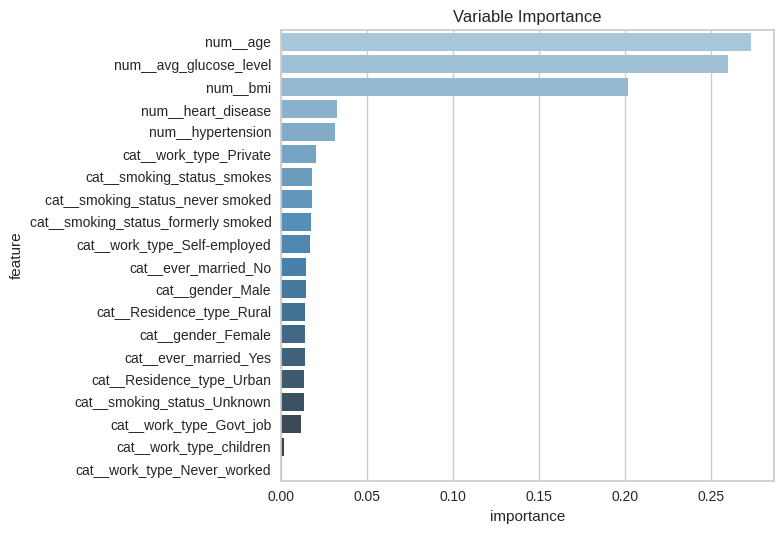

In [ ]:
best_model = grid_search.best_estimator_
importances = best_model.named_steps['classifier'].feature_importances_

# Get feature names
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Plot
sns.barplot(data=importance_df, x='importance', y='feature', palette='Blues_d')
plt.title("Variable Importance")
plt.tight_layout()
plt.show()

# Evaluate Model Performance on Test Data

In [ ]:
# ROC evaluation on test set
y_probs = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_probs)
# The change: Remove '.cat.codes', as y_test is already numeric
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Youden's J
youden_j = tpr - fpr
best_threshold = thresholds[np.argmax(youden_j)]

print("Best threshold by Youden's J:", best_threshold)

# Threshold-adjusted prediction
y_pred_opt = (y_probs >= best_threshold).astype(int)

# Confusion matrix & Metrics
print(confusion_matrix(y_test, y_pred_opt))  # Also changed here
print(classification_report(y_test, y_pred_opt)) # Also changed here

Best threshold by Youden's J: 0.05369631944852536
[[677 295]
 [  7  43]]
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       972
           1       0.13      0.86      0.22        50

    accuracy                           0.70      1022
   macro avg       0.56      0.78      0.52      1022
weighted avg       0.95      0.70      0.79      1022



ROC Curve Plot

If you want a video tutorial of how to use Google Colab and copy your notebooks into Github you can follow this link: https://youtu.be/DtuU0gZRlaY

This was work sponsored by ReproRehab: https://www.reprorehab.usc.edu/ <br>
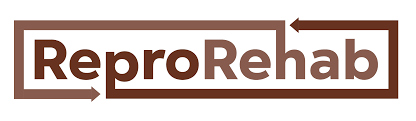